# Konecta Internship Task 4 (Customer Segmentation)

**Name:** Ahmed Ayman Ahmed Alhofy  
**Track:** Artificial Intelligence & Machine Learning  
**Repository Link:** [https://github.com/AhmedAyman4/konecta-internship/tree/main/Task-4](https://github.com/AhmedAyman4/konecta-internship/tree/main/Task-4)


### **Load & Explore**

1. Import dataset, do summary stats & distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import scipy.cluster.hierarchy as sch
from sklearn.cluster import MeanShift, estimate_bandwidth

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/Wholesale_customers_data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


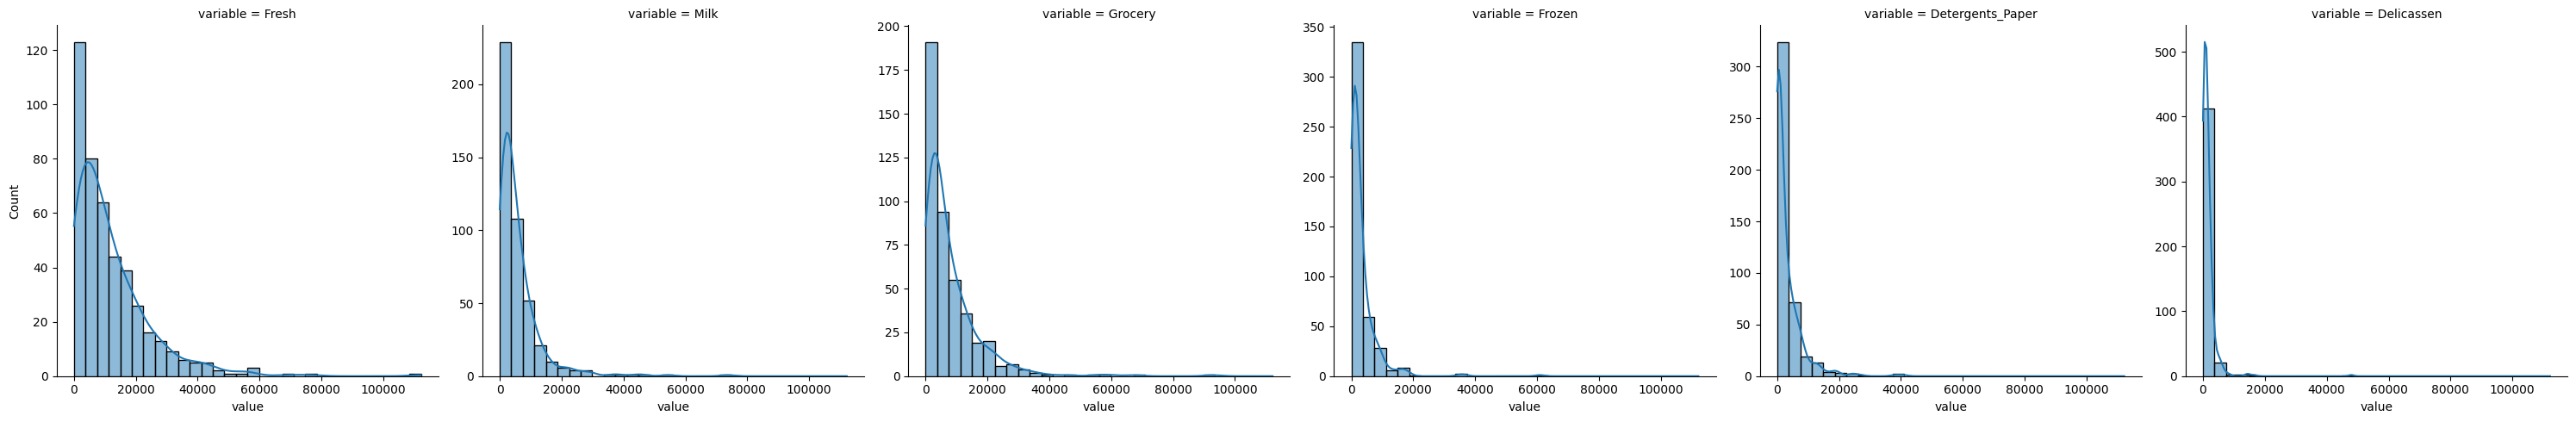

In [5]:
sns.displot(
    df.melt(value_vars=df.columns[2:]),  # reshape to long format
    x="value", col="variable", kde=True,
    facet_kws={"sharex": False, "sharey": False}, bins=30
)
# Takes all columns starting from the 3rd one (ignoring Channel and Region which are categorical).

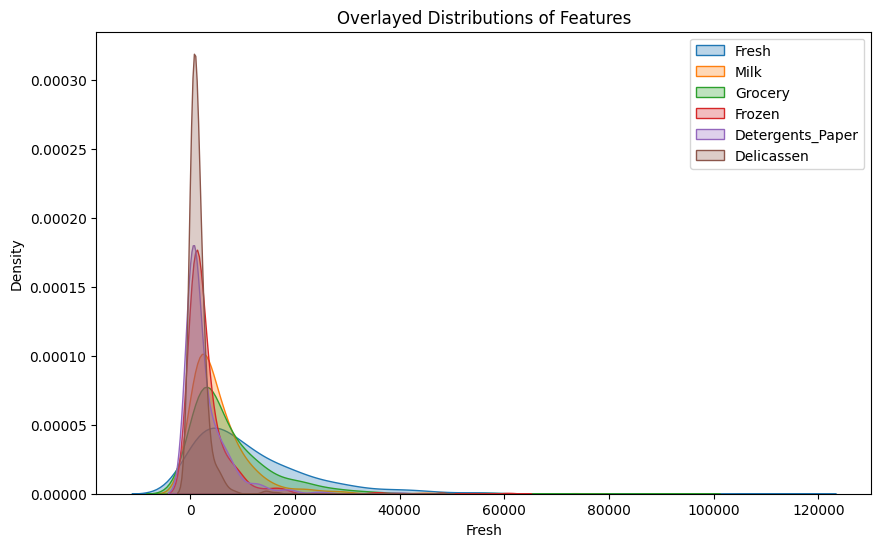

In [6]:
plt.figure(figsize=(10,6))

for col in df.columns[2:]:
    sns.kdeplot(df[col], label=col, fill=True, alpha=0.3)

plt.legend()
plt.title("Overlayed Distributions of Features")
plt.show()


Right-Skewed Distribution

### **Preprocessing**

1. Scale features (StandardScaler/MinMax).

 - StandardScaler → makes features have mean = 0 and standard deviation = 1 (like converting to z-scores).
 - MinMaxScaler → squishes all values into a fixed range, usually 0 → 1.
2. Consider log-transform (if data is skewed).
 - Apply a logarithm (log) to “compress” large values and make the distribution more balanced / closer to normal.

**In short:**
- Scaling = make all features comparable in size.
- Log-transform = reduce the effect of very large values so the data looks more balanced.


In [7]:
# Keep a copy of the original dataframe
df_original = df.copy()

# Columns you want to log-transform
cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

# Apply log1p (log(1 + x)) to avoid issues with 0 values
df[cols] = df[cols].apply(np.log1p)

Since logs can’t handle 0 values, we usually add 1 (np.log1p) to be safe.

In [8]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718


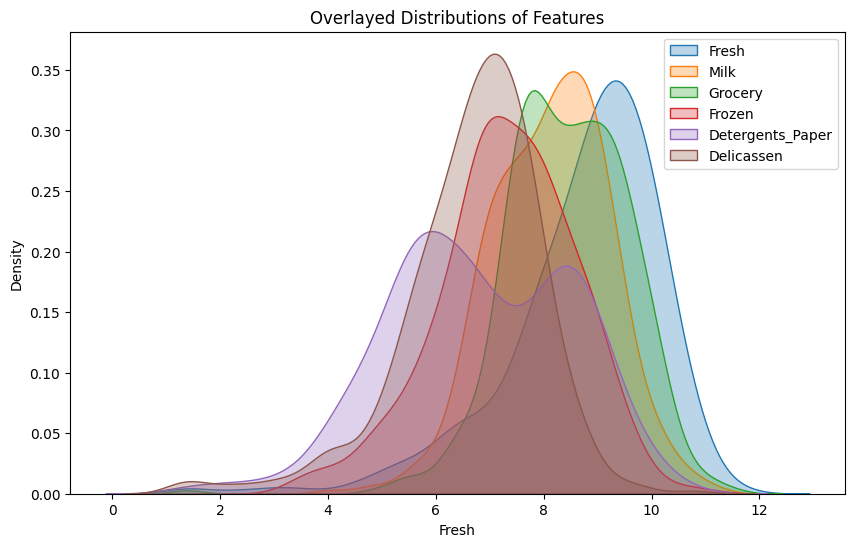

In [9]:
plt.figure(figsize=(10,6))

for col in df.columns[2:]:
    sns.kdeplot(df[col], label=col, fill=True, alpha=0.3)

plt.legend()
plt.title("Overlayed Distributions of Features")
plt.show()


### **Clustering**

1. K-Means → try different k, use Elbow/Silhouette.
2. Hierarchical → dendrograms, different linkage.
3. DBSCAN → tune eps, min_samples.
4. Meanshift Algorithm

**KMeans**

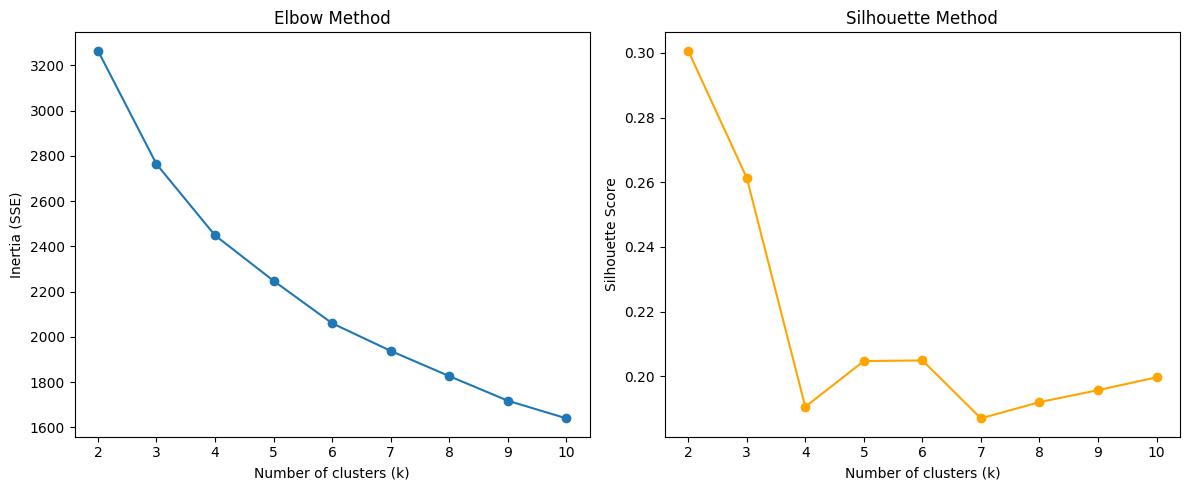

In [10]:
# K-Means → try different k, use Elbow/Silhouette.
# Columns to use (numeric features only, after log-transform)
cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
X = df[cols].values

# Range of k values to try
k_values = range(2, 11)  # from 2 to 10 clusters

inertia = []            # for Elbow method
silhouette_scores = []  # for Silhouette method

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# --- Plot Elbow Curve ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")

# --- Plot Silhouette Scores ---
plt.subplot(1,2,2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")

plt.tight_layout()
plt.show()

Fit KMeans with the chosen number of clusters

In [11]:
best_k = 6
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["Cluster"] = final_kmeans.fit_predict(X)

In [12]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,3
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,1
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,1
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,0
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,0


**Hierarchical Clustering**

Dendrogram with different linkages

- The linkage method tells how to measure distance between clusters when merging:
- single → based on the closest pair of points (can cause “chaining”).
- complete → based on the farthest pair of points (tighter clusters).
- average → based on average distance between points.
- ward → minimizes variance within clusters (most common).

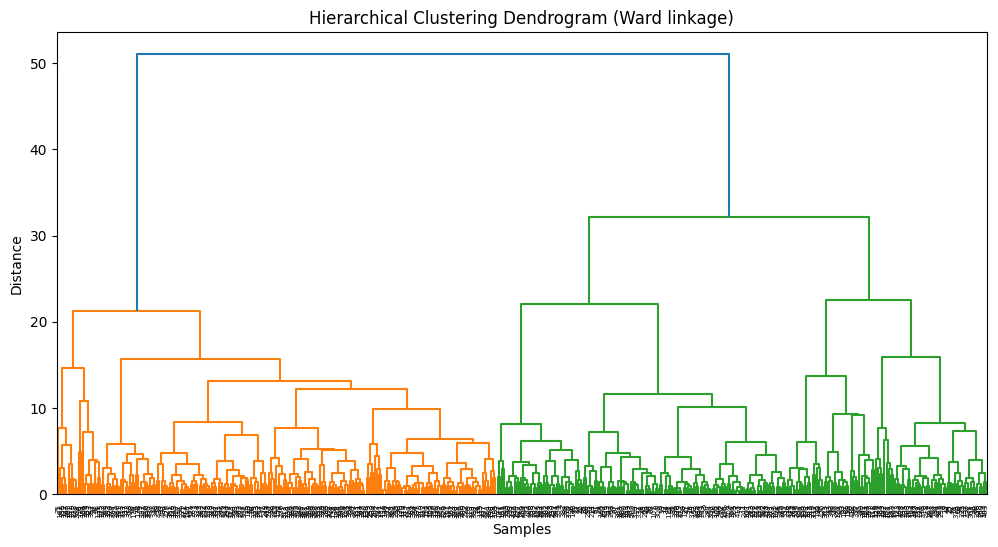

HC_Cluster
1    208
2    137
0     95
Name: count, dtype: int64


In [13]:
# Data (same features you used for KMeans)
X = df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]

# --- Dendrogram ---
plt.figure(figsize=(12,6))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

# --- Try Agglomerative Clustering with Ward linkage ---
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df["HC_Cluster"] = hc.fit_predict(X)

print(df["HC_Cluster"].value_counts())

**DBSCAN**

*   DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points that are close together into clusters.
* Unlike K-Means, you don’t need to choose k in advance.
* It also automatically detects outliers (noise points).
* eps → maximum distance between two points to be considered neighbors.
* min_samples → minimum number of points required to form a dense region (cluster).


DBSCAN_Cluster
 1    242
 0    124
-1     67
 2      7
Name: count, dtype: int64


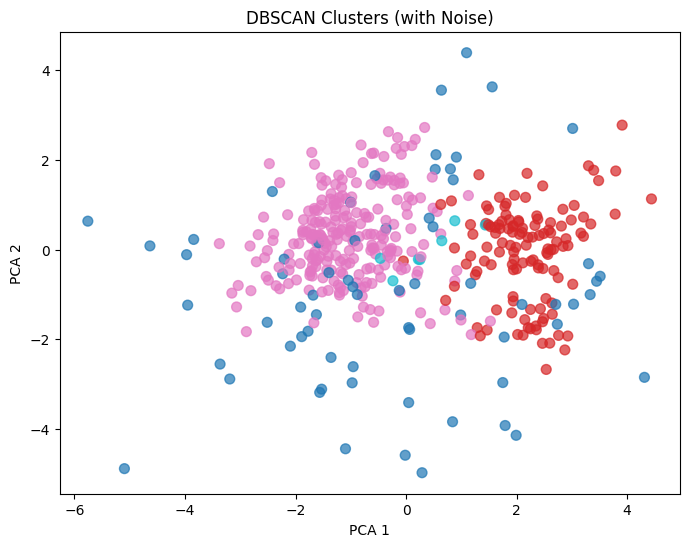

In [14]:
# Features for clustering
X = df[["Channel","Region","Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]

# Scale data (important for DBSCAN distance calculation)
X_scaled = StandardScaler().fit_transform(X)

# Try DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # tune eps & min_samples
labels = dbscan.fit_predict(X_scaled)

# Add cluster labels (note: -1 means noise/outliers)
df["DBSCAN_Cluster"] = labels

print(df["DBSCAN_Cluster"].value_counts())

# --- 2D PCA visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels, cmap="tab10", s=50, alpha=0.7
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("DBSCAN Clusters (with Noise)")
plt.show()

**What is Mean Shift?**

* Mean Shift is a clustering algorithm that does not require you to set k (number of clusters).
* It works by sliding a window (a “kernel”) across the data points and shifting it toward the densest region.
* Finally, the densest areas become cluster centers.
* bandwidth → radius of the window (how far it looks to find neighbors).

MeanShift_Cluster
0    432
1      5
2      3
Name: count, dtype: int64


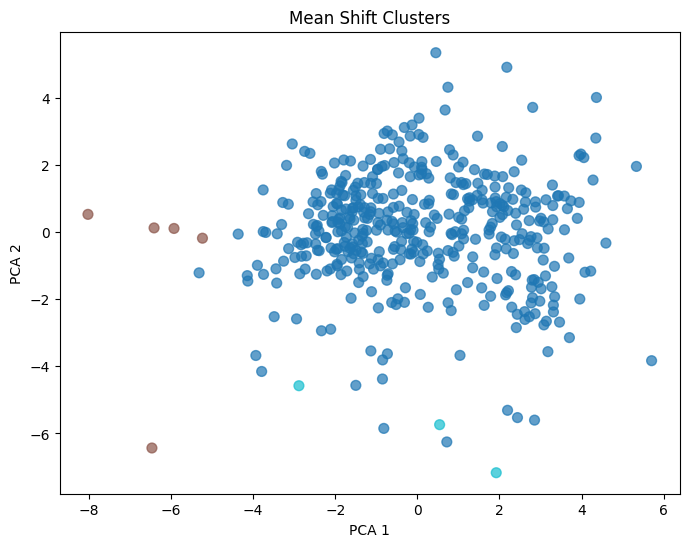

In [15]:
# Columns already log-transformed
cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

X = df[cols]  # use data as-is

# Estimate good bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.5, n_samples=200)

# Apply MeanShift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = ms.fit_predict(X)

# Add cluster labels to dataframe
df["MeanShift_Cluster"] = labels

print(df["MeanShift_Cluster"].value_counts())

# 2D PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels, cmap="tab10", s=50, alpha=0.7
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Mean Shift Clusters")
plt.show()

### **Evaluation**

1. Silhouette, Davies–Bouldin, Calinski–Harabasz.
2. Compare between methods.

**Silhouette Score**

Measures how similar a point is to its own cluster vs. other clusters.
* Range: -1 to 1
* 1 → perfectly clustered
* 0 → overlapping clusters
* Negative → probably misclassified
* Higher is better.

In [16]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X, df["Cluster"])
print("Silhouette Score:", sil_score)


Silhouette Score: 0.2049017339759311


**Davies–Bouldin Index**

* Measures the average similarity between each cluster and its most similar cluster.
* Lower is better → means clusters are well-separated.

In [17]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X, df["Cluster"])
print("Davies-Bouldin Index:", db_score)


Davies-Bouldin Index: 1.3615455691621807


**Calinski–Harabasz Index**

* Measures variance ratio between clusters vs. within clusters.
* Higher is better → clusters are dense and well-separated.

In [18]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X, df["Cluster"])
print("Calinski-Harabasz Index:", ch_score)


Calinski-Harabasz Index: 113.09769471584652


### **Visualization**

1. PCA / t-SNE for 2D plots.
2. Show how clusters separate.

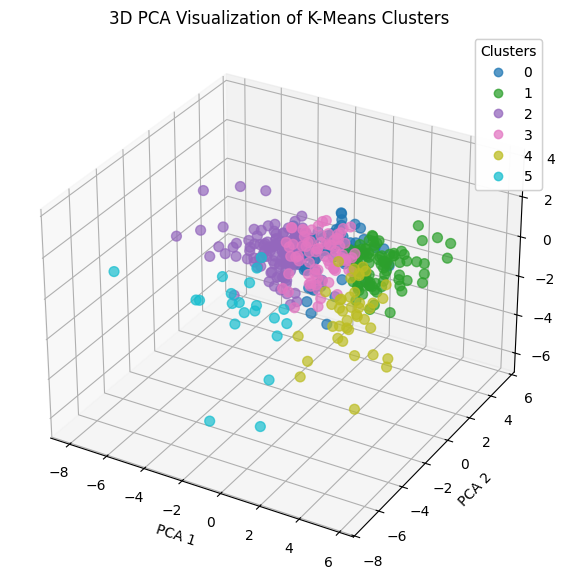

In [19]:
# Reduce dimensions to 3D with PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df[cols])

# Add PCA results to DataFrame (optional)
# We save them in df so we can plot them easily.

df["PCA1"] = X_pca[:,0] # means first column (PCA1)
df["PCA2"] = X_pca[:,1] # second column (PCA2)
df["PCA3"] = X_pca[:,2] # third column (PCA3)

# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df["PCA1"], df["PCA2"], df["PCA3"], # → the x, y, z coordinates
    c=df["Cluster"], cmap="tab10", s=50, alpha=0.7
)

# Labels
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Visualization of K-Means Clusters")

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

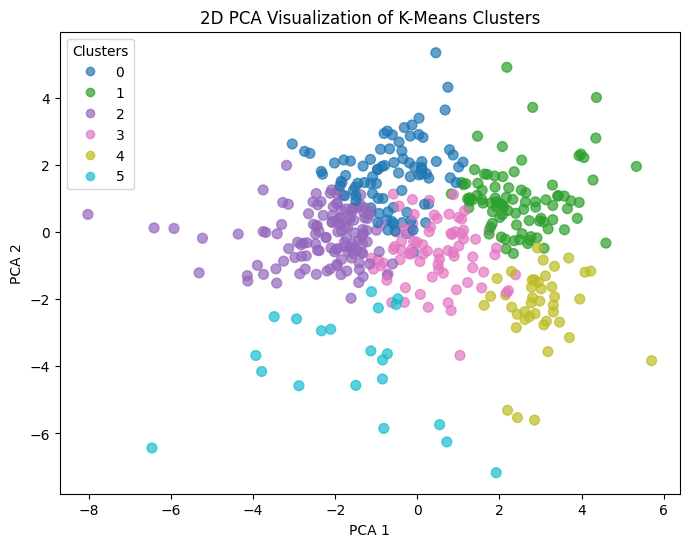

In [20]:
# 2D scatter plot using PCA1 and PCA2
plt.figure(figsize=(8,6))
plt.scatter(
    df["PCA1"], df["PCA2"],
    c=df["Cluster"], cmap="tab10", s=50, alpha=0.7
)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("2D PCA Visualization of K-Means Clusters")

# Legend for clusters
plt.legend(*plt.gca().collections[0].legend_elements(), title="Clusters")

plt.show()


In [21]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster,HC_Cluster,DBSCAN_Cluster,MeanShift_Cluster,PCA1,PCA2,PCA3
0,2,3,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,3,2,0,0,1.746904,0.062700,0.975606
1,2,3,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,1,2,0,0,1.793552,0.869707,-0.212709
2,2,3,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,1,2,0,0,1.884226,1.669358,-1.297679
3,1,3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,0,1,1,0,-1.137087,1.449765,-0.539310
4,2,3,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,0,2,0,0,0.784600,2.453600,-0.459114


### **Interpretation**

1. Describe customer segments in plain words (e.g. high Grocery & Milk = retailers).

In [22]:
# the average spending per product category for each cluster.
cluster_summary_log = df.groupby("Cluster")[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].mean()
cluster_summary_log


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,9.576697,8.216473,8.321770,8.739390,6.348646,7.524453
1,9.010294,9.211809,9.626438,7.333320,8.746333,7.515059
2,9.178045,7.196427,7.435917,7.517002,5.090613,6.268230
3,8.851209,8.154713,8.494879,6.480139,7.222249,6.080108
4,6.350919,8.915456,9.585153,5.751892,8.807320,6.377906
5,5.653356,7.043041,7.583527,6.096944,5.089056,4.824471


In [23]:
# Copy cluster labels from transformed df to original df
df_original["Cluster"] = df["Cluster"]

# Group by cluster on the original data
cluster_summary = df_original.groupby("Cluster")[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].mean()

cluster_summary


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,20715.220930,5267.662791,5008.767442,8349.267442,755.046512,2883.337209
1,12013.761364,12751.340909,18169.636364,2169.227273,8084.454545,2486.477273
2,12777.634921,1798.103175,2144.547619,2530.365079,236.134921,746.492063
3,9882.012821,4368.166667,6070.320513,968.025641,1838.358974,735.243590
4,1161.195122,8785.439024,16116.268293,530.195122,7557.780488,1109.146341
5,620.142857,2273.285714,3067.380952,1269.095238,403.666667,346.857143


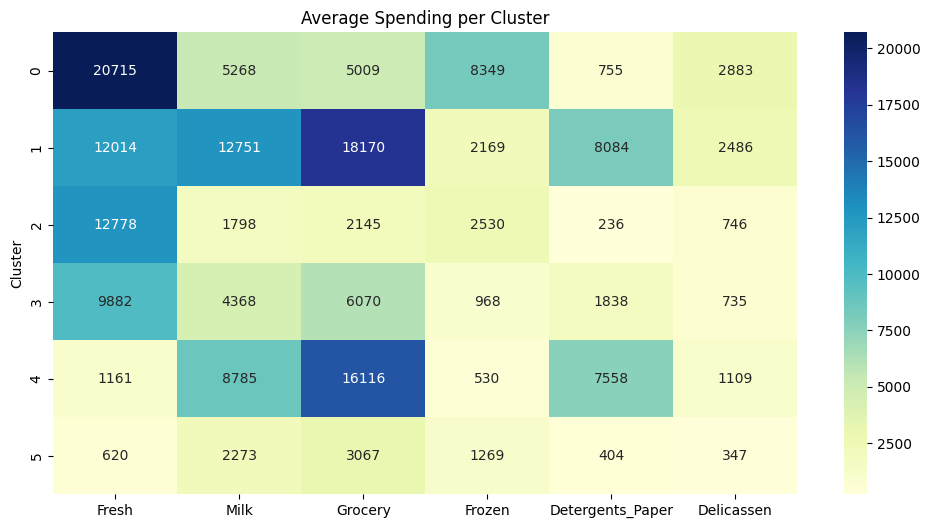

In [24]:
plt.figure(figsize=(12,6))
sns.heatmap(cluster_summary, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Spending per Cluster")
plt.show()

This heatmap makes it clear which features are dominant in each cluster.

**Customer Segments (Heatmap: Avg Spending per Cluster)**

- **Cluster 0: "Fresh & Frozen"** 🍎  
High spend on **Fresh** and **Frozen**, low elsewhere — likely meal preppers or small food businesses.

- **Cluster 1: "Bulk Buyers / Retailers"** 🛒  
High spending on **Fresh**, **Milk**, **Grocery**, and **Detergents_Paper** — likely retailers, restaurants, or large families.

- **Cluster 2: "Fresh-First Shoppers"** 🥕  
Focused almost entirely on **Fresh** — may buy other items elsewhere or run a produce-focused business.

- **Cluster 3: "Household Essentials"** 🧼  
Moderate on groceries, highest on **Detergents_Paper** — typical household prioritizing cleaning supplies.

- **Cluster 4: "Grocery & Milk"** 🥛  
High on **Grocery** and **Milk**, low on Fresh — possibly small stores or families favoring packaged/dairy goods.

- **Cluster 5: "Low-Volume Shoppers"** 🤏  
Low spending across all categories — infrequent shoppers, singles, or supplemental customers.